# Sleep Efficiency Analysis

## 1. Introduction
This notebook analyzes sleep efficiency based on various physiological and behavioral variables. It includes data inspection, preprocessing, exploratory data analysis (EDA), and modeling using machine learning techniques.

## 2. Data Import & Overview

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import Ridge, Lasso, LassoCV, ElasticNet, LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedShuffleSplit, cross_validate, KFold
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, mean_absolute_error, r2_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, GradientBoostingRegressor
from sklearn.feature_selection import RFECV

# Set random state for reproducibility
RANDOM_STATE = 42

# Load dataset
df = pd.read_csv('data/Sleep_Efficiency.csv')
print(df.head())

   ID  Age  Gender              Bedtime          Wakeup time  Sleep duration  \
0   1   65  Female  2021-03-06 01:00:00  2021-03-06 07:00:00             6.0   
1   2   69    Male  2021-12-05 02:00:00  2021-12-05 09:00:00             7.0   
2   3   40  Female  2021-05-25 21:30:00  2021-05-25 05:30:00             8.0   
3   4   40  Female  2021-11-03 02:30:00  2021-11-03 08:30:00             6.0   
4   5   57    Male  2021-03-13 01:00:00  2021-03-13 09:00:00             8.0   

   Sleep efficiency  REM sleep percentage  Deep sleep percentage  \
0              0.88                    18                     70   
1              0.66                    19                     28   
2              0.89                    20                     70   
3              0.51                    23                     25   
4              0.76                    27                     55   

   Light sleep percentage  Awakenings  Caffeine consumption  \
0                      12         0.0          

### 2.1 Data Types & Structure

In [3]:
# Check data types
print(df.dtypes)

ID                          int64
Age                         int64
Gender                     object
Bedtime                    object
Wakeup time                object
Sleep duration            float64
Sleep efficiency          float64
REM sleep percentage        int64
Deep sleep percentage       int64
Light sleep percentage      int64
Awakenings                float64
Caffeine consumption      float64
Alcohol consumption       float64
Smoking status             object
Exercise frequency        float64
dtype: object


### 2.2 Feature Overview

In [4]:
# Examine properties
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      452 non-null    int64  
 1   Age                     452 non-null    int64  
 2   Gender                  452 non-null    object 
 3   Bedtime                 452 non-null    object 
 4   Wakeup time             452 non-null    object 
 5   Sleep duration          452 non-null    float64
 6   Sleep efficiency        452 non-null    float64
 7   REM sleep percentage    452 non-null    int64  
 8   Deep sleep percentage   452 non-null    int64  
 9   Light sleep percentage  452 non-null    int64  
 10  Awakenings              432 non-null    float64
 11  Caffeine consumption    427 non-null    float64
 12  Alcohol consumption     438 non-null    float64
 13  Smoking status          452 non-null    object 
 14  Exercise frequency      446 non-null    fl

### 2.3 Descriptive Statistics

In [5]:
# Generate summary statistics
print(df.describe())

               ID         Age  Sleep duration  Sleep efficiency  \
count  452.000000  452.000000      452.000000        452.000000   
mean   226.500000   40.285398        7.465708          0.788916   
std    130.625419   13.172250        0.866625          0.135237   
min      1.000000    9.000000        5.000000          0.500000   
25%    113.750000   29.000000        7.000000          0.697500   
50%    226.500000   40.000000        7.500000          0.820000   
75%    339.250000   52.000000        8.000000          0.900000   
max    452.000000   69.000000       10.000000          0.990000   

       REM sleep percentage  Deep sleep percentage  Light sleep percentage  \
count            452.000000             452.000000              452.000000   
mean              22.615044              52.823009               24.561947   
std                3.525963              15.654235               15.313665   
min               15.000000              18.000000                7.000000   
25%   

## 3. Data Preprocessing

In [6]:
# Handle missing values
df.ffill(inplace=True)

# Convert data types
df['Awakenings'] = df['Awakenings'].astype('int64')
df['Caffeine consumption'] = df['Caffeine consumption'].astype('int64')
df['Alcohol consumption'] = df['Alcohol consumption'].astype('int64')
df['Exercise frequency'] = df['Exercise frequency'].astype('int64')

# Omzetten naar datetime
df['Bedtime'] = pd.to_datetime(df['Bedtime'])
df['Wakeup time'] = pd.to_datetime(df['Wakeup time'])

# One-hot encode categorical features by using the .get_dummies()
df = pd.get_dummies(df, columns=['Gender', 'Smoking status'], dtype=float)

# drop the columns which are not relevant
df = df.drop(columns=['ID'])

# Rename all columns to lower case and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Normalize or standardize numerical features
df_numeric = df.select_dtypes(include=['number'])
# .drop(columns=['Age', 'Sleep duration'])  # Selecteer alleen numerieke kolommen met uitzondering van 2 kolommen
df[df_numeric.columns] = (df_numeric - df_numeric.mean()) / df_numeric.std()

## 4. Exploratory Data Analysis

### 4.1 Histograms

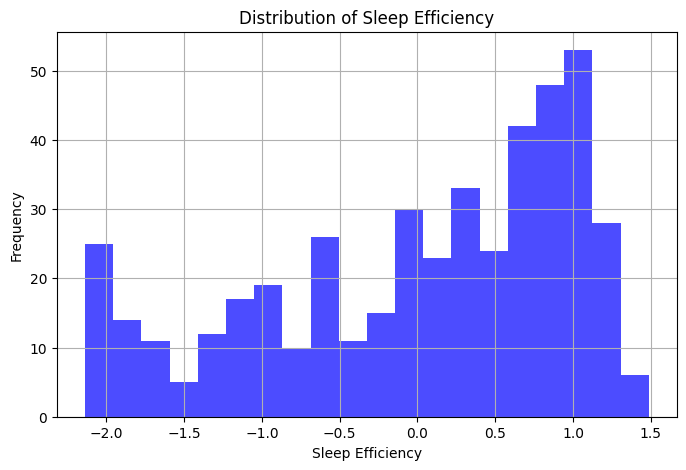

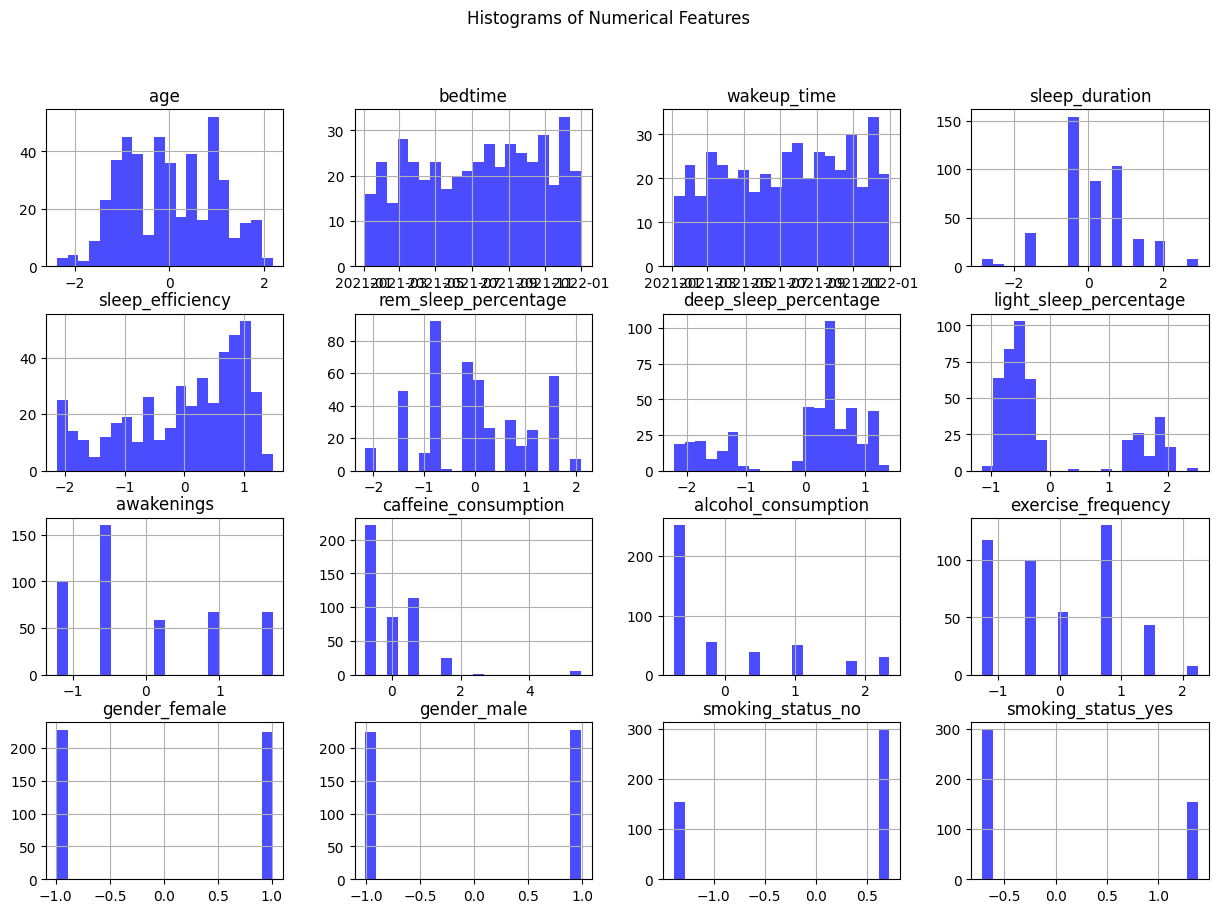

In [7]:
# Plot histogram for a single feature
plt.figure(figsize=(8, 5))
plt.hist(df['sleep_efficiency'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Sleep Efficiency')
plt.xlabel('Sleep Efficiency')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot histograms for all numerical features
df.hist(bins=20, figsize=(15, 10), color='blue', alpha=0.7)
plt.suptitle('Histograms of Numerical Features')
plt.show()

### 4.2 Box Plots

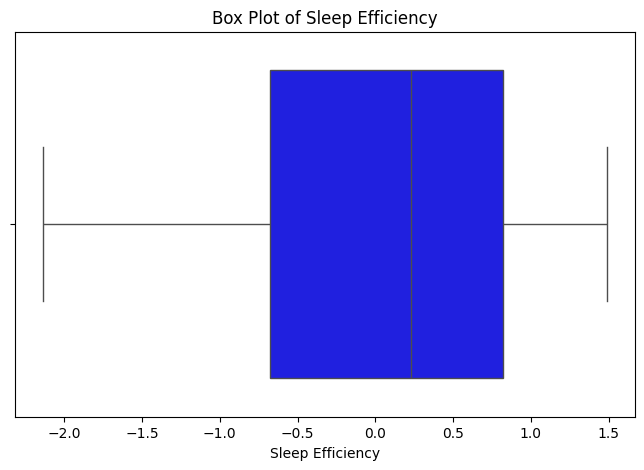

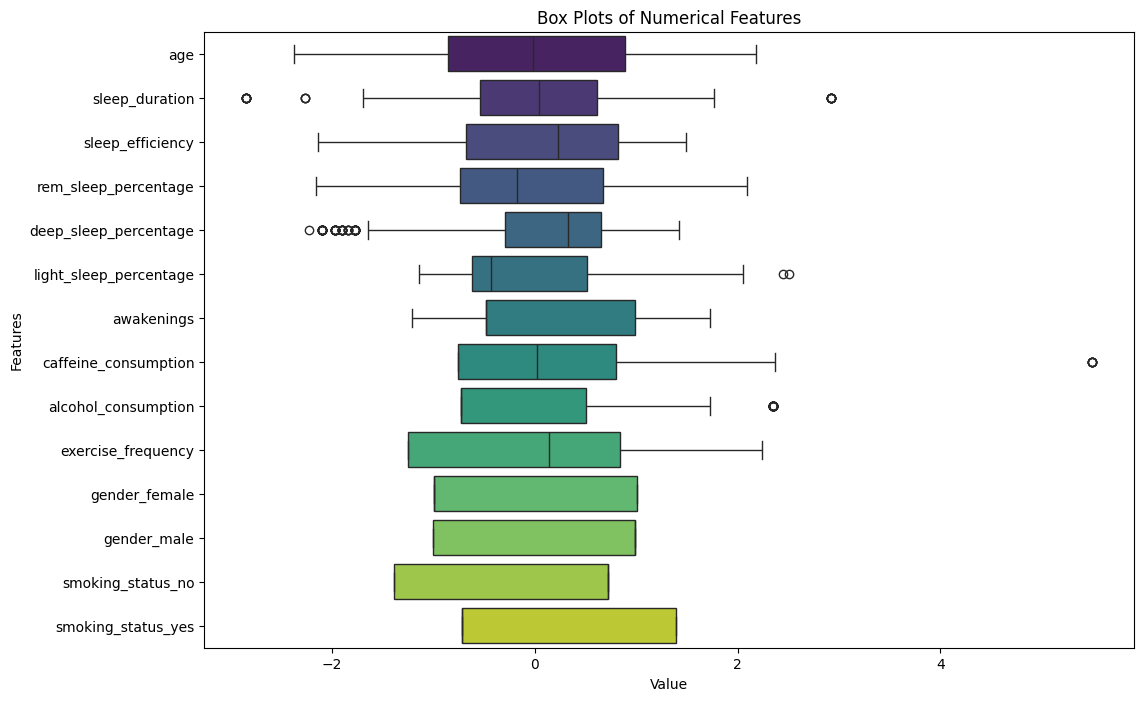

In [8]:
# Plot box plot for a single feature
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['sleep_efficiency'], color='blue')
plt.title('Box Plot of Sleep Efficiency')
plt.xlabel('Sleep Efficiency')
plt.show()

# Plot box plots for all numerical features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']), orient='h', palette='viridis')
plt.title('Box Plots of Numerical Features')
plt.xlabel('Value')
plt.ylabel('Features')
plt.show()

### 4.3a Correlation Matrix

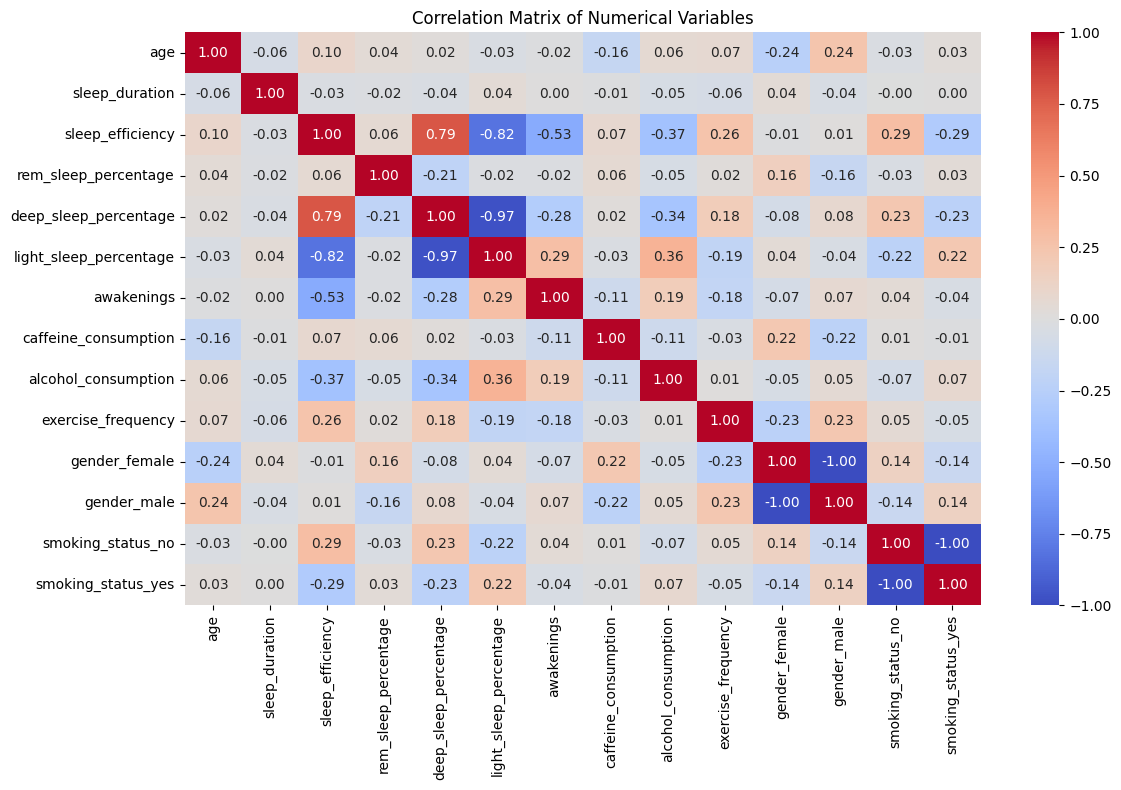


Correlations with Sleep efficiency Score:

sleep_efficiency          1.000000
deep_sleep_percentage     0.787335
smoking_status_no         0.290026
exercise_frequency        0.255953
age                       0.098357
caffeine_consumption      0.071752
rem_sleep_percentage      0.062362
gender_male               0.010062
gender_female            -0.010062
sleep_duration           -0.027467
smoking_status_yes       -0.290026
alcohol_consumption      -0.372177
awakenings               -0.529961
light_sleep_percentage   -0.819204
Name: sleep_efficiency, dtype: float64

Correlations with Deep Sleep Percentage:

deep_sleep_percentage     1.000000
sleep_efficiency          0.787335
smoking_status_no         0.226802
exercise_frequency        0.181551
gender_male               0.075939
age                       0.021730
caffeine_consumption      0.016488
sleep_duration           -0.037304
gender_female            -0.075939
rem_sleep_percentage     -0.208159
smoking_status_yes       -0.226802

In [9]:
# Select numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

# Print correlations with Sleep efficiency
print("\nCorrelations with Sleep efficiency Score:\n")
productivity_correlations = correlation_matrix['sleep_efficiency'].sort_values(ascending=False)
print(productivity_correlations)

# Print correlations with Awakenings
print("\nCorrelations with Deep Sleep Percentage:\n")
productivity_correlations = correlation_matrix['deep_sleep_percentage'].sort_values(ascending=False)
print(productivity_correlations)

# Print correlations with Awakenings
print("\nCorrelations with Light Sleep Percentage:\n")
productivity_correlations = correlation_matrix['light_sleep_percentage'].sort_values(ascending=False)
print(productivity_correlations)

# Print correlations with Awakenings
print("\nCorrelations with Awakenings Score:\n")
productivity_correlations = correlation_matrix['awakenings'].sort_values(ascending=False)
print(productivity_correlations)


Based on the combined analysis of `sleep_efficiency`, `deep_sleep_percentage`, and `awakenings`, we identify which variables are worth keeping and which can be removed due to low impact.

**Key Variables to **Keep** (Strong correlation with at least one target)**

| Variable              | Reason to Keep |
|-----------------------|----------------|
| `sleep_efficiency`    | Target variable / strongly related to others |
| `deep_sleep_percentage` | Strong positive impact on efficiency and negative on awakenings |
| `light_sleep_percentage` | Strong negative effect on efficiency and deep sleep; positive on awakenings |
| `awakenings`          | Strongly lowers efficiency and deep sleep |
| `exercise_frequency`  | Positive effect across all sleep metrics |
| `alcohol_consumption` | Negative effect across the board |
| `smoking_status_yes`  | Negative correlation with efficiency and deep sleep |

**Variables to **Remove** (Low or no impact on targets)**

| Variable               | Reason for Removal |
|------------------------|--------------------|
| `REM_sleep_percentage` | No meaningful correlation with any target (max 0.06) |
| `caffeine_consumption` | Weak or no correlation across the board |
| `age`                  | Minimal influence (correlations between 0.02 and 0.10) |
| `gender_female`        | Very weak correlation (~ -0.01) |
| `gender_male`          | Very weak correlation (~ 0.08) |
| `sleep_duration`       | No impact on efficiency (correlation: -0.03) |
| `smoking_status_no`    | Redundant with `smoking_status_yes` (binary encoding) |


### 4.3b Reduced correlation matrix

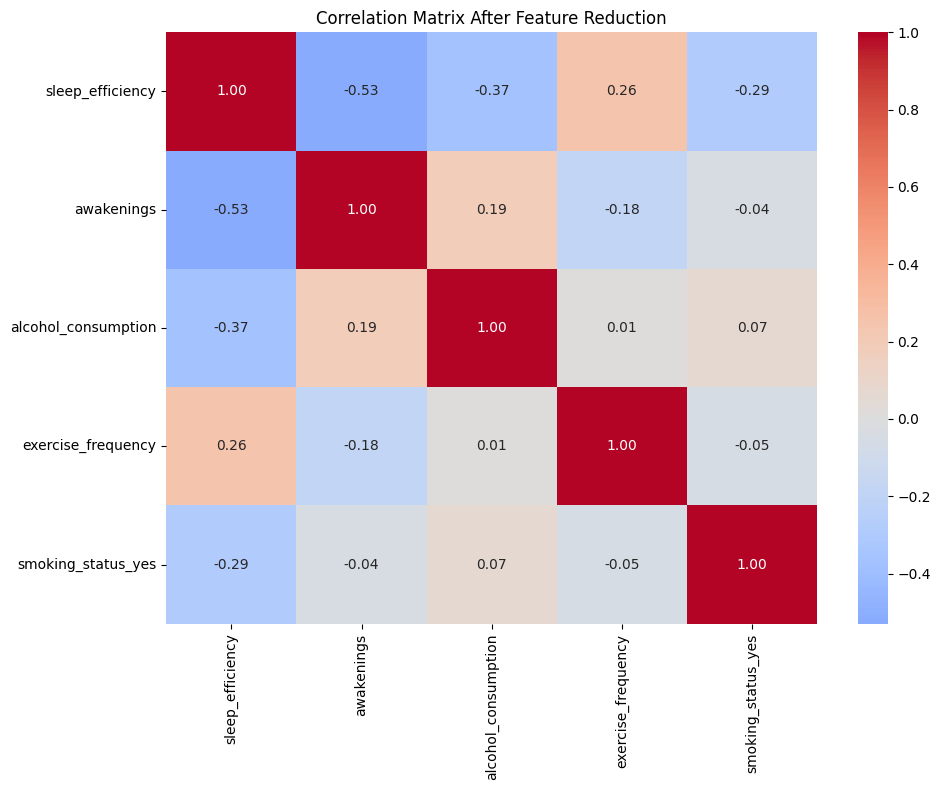

In [10]:
# drop the columns which are not not important and have multicollinearity issues
df_split = df.drop(columns=['light_sleep_percentage', 'deep_sleep_percentage', 'rem_sleep_percentage', 'caffeine_consumption', 'age', 'gender_female', 'gender_male', 'smoking_status_no', 'sleep_duration', 'bedtime', 'wakeup_time'])

# Calculate correlation matrix on the cleaned dataset (X only, no target)
corr_matrix_cleaned = df_split.corr()

# Plot the heatmap ( FOR THE CLEANED SET)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_cleaned, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix After Feature Reduction')
plt.tight_layout()
plt.show()

### 4.4 Splitting Data

In [11]:
# drop the columns which are not nummeric
df_split = df.drop(columns=['light_sleep_percentage', 'deep_sleep_percentage','rem_sleep_percentage', 'caffeine_consumption', 'age', 'gender_female', 'gender_male', 'smoking_status_no', 'sleep_duration', 'bedtime', 'wakeup_time'])

# Separate features and target variable
X = df_split.drop(columns=['sleep_efficiency'])  # Assuming 'Sleep efficiency' is the target variable
y = df_split['sleep_efficiency'].astype('float')

# Split the data into training and testing sets (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### 4.5 Classification

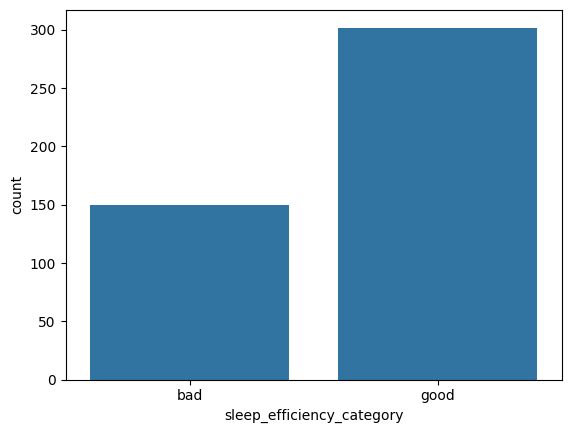

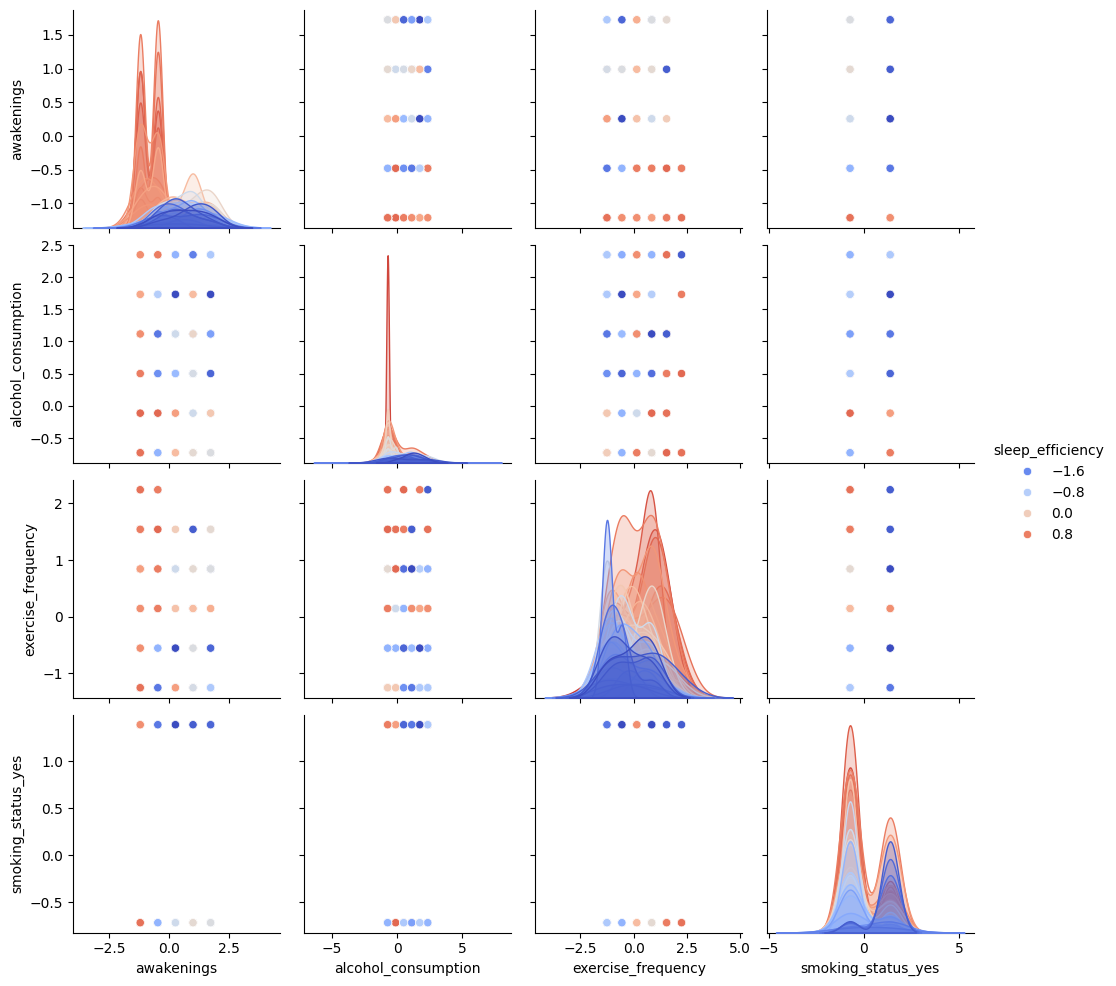

Accuracy: 0.8461538461538461
              precision    recall  f1-score   support

         bad       0.75      0.75      0.75        28
        good       0.89      0.89      0.89        63

    accuracy                           0.85        91
   macro avg       0.82      0.82      0.82        91
weighted avg       0.85      0.85      0.85        91



In [12]:
# Bin the continuous target variable into discrete classes
df_split_cat = copy.deepcopy(df_split)
df_split_cat['sleep_efficiency_category'] = pd.cut(df_split['sleep_efficiency'], bins=2, labels=['bad', 'good'])

# Visualize target categories of sleep efficiency
sns.countplot(x='sleep_efficiency_category', data=df_split_cat)
plt.show()

# Analyze relationships
sns.pairplot(df_split, hue='sleep_efficiency', palette='coolwarm')
plt.show()

# Update the target variable for classification
y_train_class = pd.cut(y_train, bins=2, labels=['bad', 'good'])
y_test_class = pd.cut(y_test, bins=2, labels=['bad', 'good'])

# Train classification model
model = DecisionTreeClassifier()
model.fit(X_train, y_train_class)

# Evaluate classification model
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_class, y_pred)}")
print(classification_report(y_test_class, y_pred))

### 4.6 Pair Plot

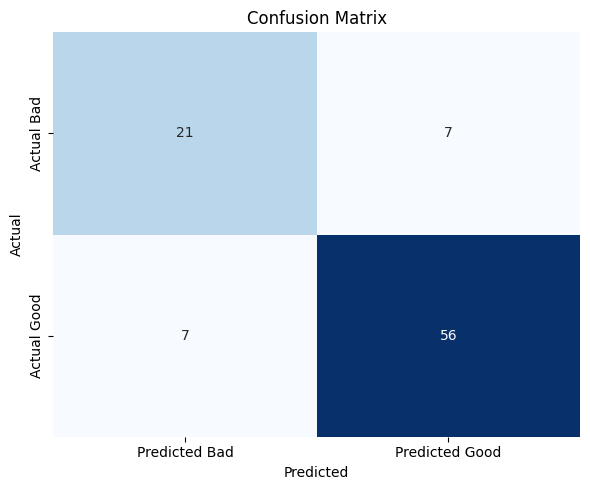

In [13]:
# calculating the confusion matrix
cm = confusion_matrix(y_test_class, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Bad', 'Predicted Good'],
            yticklabels=['Actual Bad', 'Actual Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### 4.7 Hyperparameter Tuning

In [14]:
# Hyperparameter tuning with Decision Tree 
param_grid = {'max_depth': [3, 5, 7, 10]}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train_class)
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': 5}


In [15]:
# Hyperparameter tuning with RandomForest
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [50, 100, 200]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train_class)
print(grid.best_params_)

{'max_depth': 7, 'n_estimators': 50}


### 4.7 Regression bulk testing

In [16]:
# Simple Linear Regressor
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Simple Linear Regressor): {mean_squared_error(y_test, y_pred)}")

# Standard Scaling + Linear Regressor
model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Standard Scaling + Linear Regressor): {mean_squared_error(y_test, y_pred)}")

# Normalizer + Linear Regressor
model = make_pipeline(Normalizer(), LinearRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Normalizer + Linear Regressor): {mean_squared_error(y_test, y_pred)}")

# Ridge Regression
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Ridge Regression): {mean_squared_error(y_test, y_pred)}")

# Lasso Regression
model = Lasso()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Lasso Regression): {mean_squared_error(y_test, y_pred)}")

# ElasticNet Regression
model = ElasticNet()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (ElasticNet Regression): {mean_squared_error(y_test, y_pred)}")

# Simple Polynomial Linear Regressor
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
model = LinearRegression()
model.fit(X_poly, y_train)
X_test_poly = poly.transform(X_test)
y_pred = model.predict(X_test_poly)
print(f"Mean Squared Error (Simple Polynomial Linear Regressor): {mean_squared_error(y_test, y_pred)}")

# Ridge Polynomial Linear Regressor
model = make_pipeline(PolynomialFeatures(degree=2), Ridge())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Ridge Polynomial Linear Regressor): {mean_squared_error(y_test, y_pred)}")

# Lasso Polynomial Linear Regressor
model = make_pipeline(PolynomialFeatures(degree=2), Lasso())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Lasso Polynomial Linear Regressor): {mean_squared_error(y_test, y_pred)}")

# ElasticNet Polynomial Linear Regressor
model = make_pipeline(PolynomialFeatures(degree=2), ElasticNet())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (ElasticNet Polynomial Linear Regressor): {mean_squared_error(y_test, y_pred)}")

# Gradient boosting
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Gradient boosting Regressor): {mean_squared_error(y_test, y_pred)}")

# Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Random Forest Regressor): {mean_squared_error(y_test, y_pred)}")

Mean Squared Error (Simple Linear Regressor): 0.521729895735661
Mean Squared Error (Standard Scaling + Linear Regressor): 0.521729895735661
Mean Squared Error (Normalizer + Linear Regressor): 0.5454303455136394
Mean Squared Error (Ridge Regression): 0.5219437574080775
Mean Squared Error (Lasso Regression): 1.0197174457337157
Mean Squared Error (ElasticNet Regression): 0.9954853606754386
Mean Squared Error (Simple Polynomial Linear Regressor): 0.41185502072441504
Mean Squared Error (Ridge Polynomial Linear Regressor): 0.41171781943737534
Mean Squared Error (Lasso Polynomial Linear Regressor): 1.0197174457337157
Mean Squared Error (ElasticNet Polynomial Linear Regressor): 0.9954853606754386
Mean Squared Error (Gradient boosting Regressor): 0.4113458647427646
Mean Squared Error (Random Forest Regressor): 0.39221406341043036


## 5. Modeling

### 5.0 Initial setup

In [17]:
# Help function
def print_results(results, model_name):
    print(f"{model_name}")
    print(f"MAE: {results['test_MAE'].mean():.4f} ± {results['test_MAE'].std():.4f}")
    print(f"MSE: {results['test_MSE'].mean():.4f} ± {results['test_MSE'].std():.4f}")
    print(f"R2: {results['test_R2'] .mean():.4f} ± {results['test_R2'] .std():.4f}")

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'R2' : make_scorer(r2_score),
}


### 5.1 Gradient Boosting

In [18]:
model_gbr = GradientBoostingRegressor()

gbr_baseline_results = cross_validate(
    model_gbr, X, y,
    cv=outer_cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

print_results(gbr_baseline_results, "Gradient Boosting Regressor (no tuning)")


Gradient Boosting Regressor (no tuning)
MAE: 0.4741 ± 0.0267
MSE: 0.4027 ± 0.0447
R2: 0.5898 ± 0.0696


**Using GridSearchCV and KFold to Improve Model Performance**

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    "subsample": [0.8, 1.0],
}

gbr_gscv = GridSearchCV(estimator=model_gbr, param_grid=param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)

gbr_cv_results = cross_validate(
    gbr_gscv, X, y,
    cv=outer_cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

print_results(gbr_cv_results, "Gradient Boosting Regressor (tuning)")

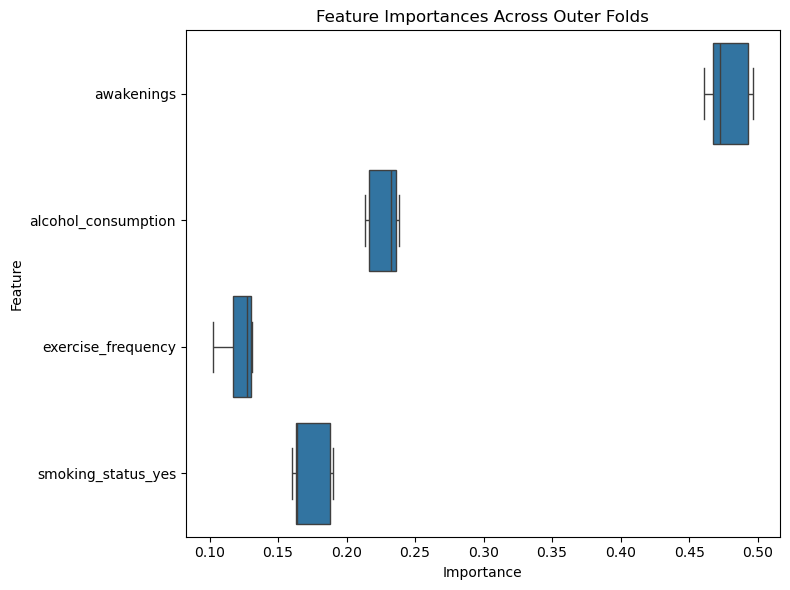

In [ ]:
# grab each outer‐fold’s fitted estimator:
all_imps = np.vstack([
    est.best_estimator_.feature_importances_
    for est in gbr_cv_results['estimator']
])

df_imps = pd.DataFrame(all_imps, columns=X.columns)
df_melt = df_imps.melt(var_name='Feature', value_name='Importance')

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_melt, x='Importance', y='Feature', orient='h')
plt.title('Feature Importances Across Outer Folds')
plt.tight_layout()
plt.show()


**Features importances**

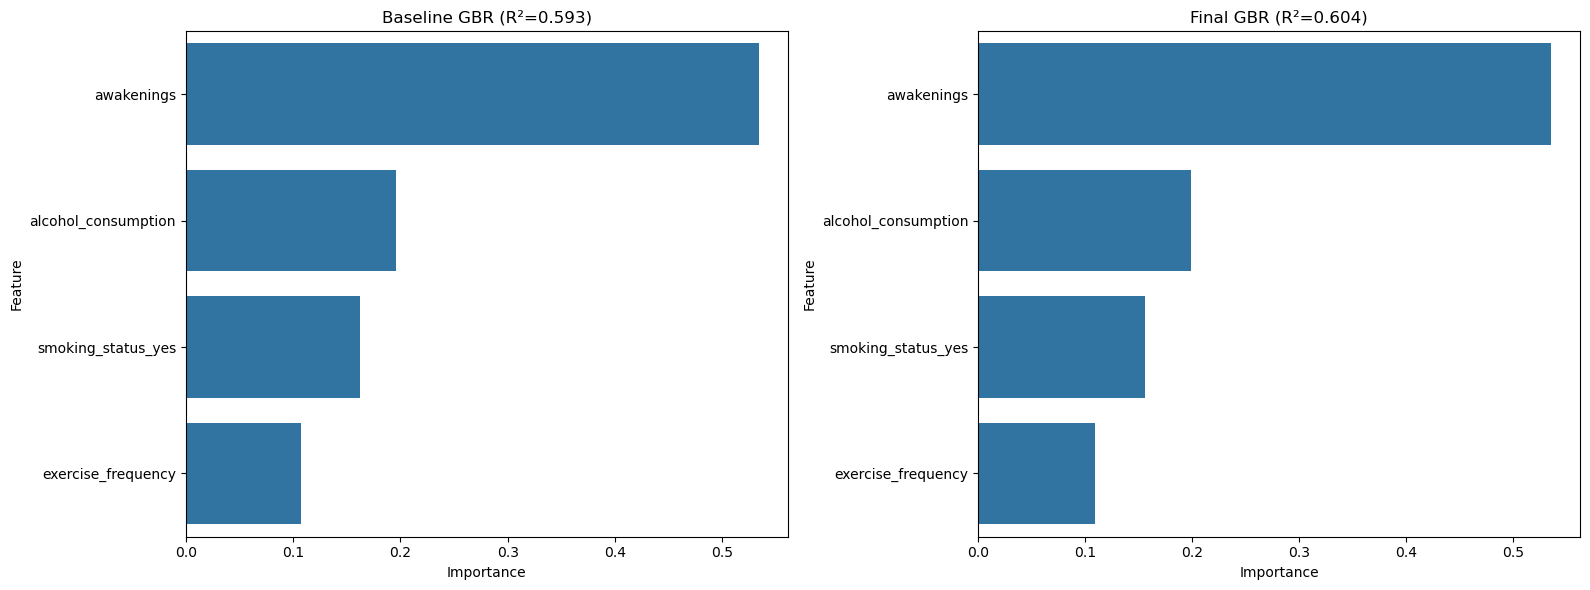

In [ ]:
final_gbr = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=inner_cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0,
    refit=True
).fit(X_train, y_train)

base_gbr = GradientBoostingRegressor().fit(X_train, y_train)

feature_importances_global = pd.DataFrame({
    'Feature':    X.columns,
    'Importance': final_gbr.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importances_baseline = pd.DataFrame({
    'Feature':    X.columns,
    'Importance': base_gbr.feature_importances_
}).sort_values('Importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x='Importance', y='Feature', data=feature_importances_baseline, ax=axes[0])
axes[0].set_title(f'Baseline GBR (R²={r2_score(y_test, base_gbr.predict(X_test)):.3f})')
sns.barplot(x='Importance', y='Feature', data=feature_importances_global, ax=axes[1])
axes[1].set_title(f'Final GBR (R²={r2_score(y_test, final_gbr.predict(X_test)):.3f})')

plt.tight_layout()
plt.show()


### 5.2 Lasso Regression

In [ ]:
model_l = Lasso(alpha=0.1)

lasso_baseline_results = cross_validate(
    model_l, X, y,
    cv=outer_cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

print_results(lasso_baseline_results, "Lasso Regressor (no tuning)")

Lasso Regressor (no tuning)
MAE: 0.6145 ± 0.0180
MSE: 0.5741 ± 0.0325
R2: 0.4199 ± 0.0375


**Using LassoCV and KFold to Improve Model Performance** 

In [ ]:
param_grid = {
    'alphas': [0.01, 0.1, 1, 10]
}

lasso_cv = LassoCV(alphas=param_grid['alphas'], cv=inner_cv, n_jobs=-1)

lasso_cv_results = cross_validate(
    lasso_cv, X, y,
    cv=outer_cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

print_results(lasso_cv_results, "Lasso Regressor (tuning)")


Lasso Regressor (tuning)
MAE: 0.5875 ± 0.0128
MSE: 0.5426 ± 0.0284
R2: 0.4501 ± 0.0546


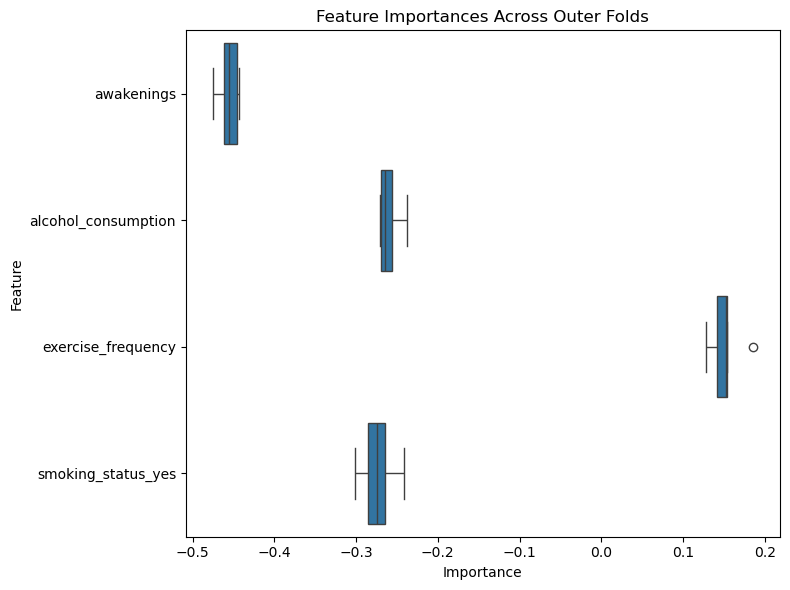

In [ ]:
# grab each outer‐fold’s fitted estimator:
all_imps = np.vstack([
    est.coef_
    for est in lasso_cv_results['estimator']
])

df_imps = pd.DataFrame(all_imps, columns=X.columns)
df_melt = df_imps.melt(var_name='Feature', value_name='Importance')

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_melt, x='Importance', y='Feature', orient='h')
plt.title('Feature Importances Across Outer Folds')
plt.tight_layout()
plt.show()

**Features importances**

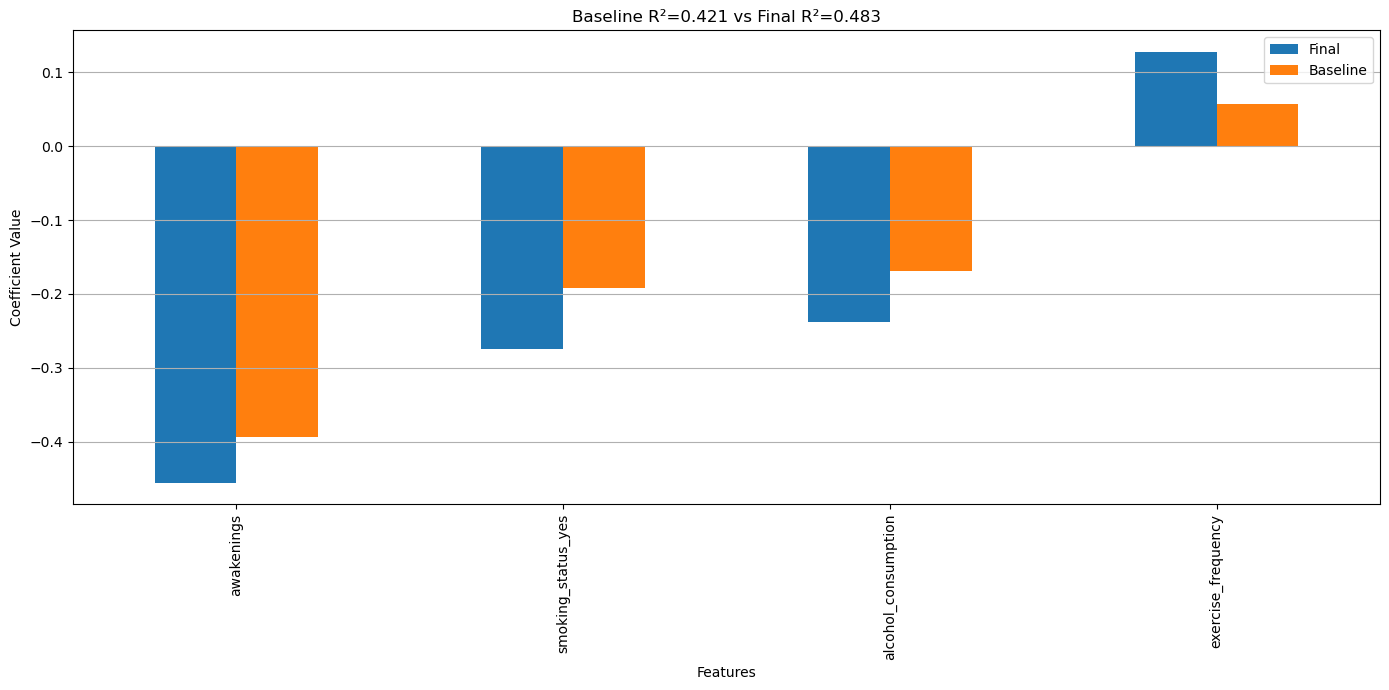

In [ ]:
baseline_lasso = Lasso(alpha=0.1).fit(X_train, y_train)

final_lasso = LassoCV(
    alphas=param_grid['alphas'],
    cv=inner_cv,
    n_jobs=-1,
    random_state=42
).fit(X_train, y_train)


coef_final = pd.Series(final_lasso.coef_, index=X.columns, name='Final')
coef_baseline = pd.Series(baseline_lasso.coef_, index=X.columns, name='Baseline')

coefs = pd.concat([coef_final, coef_baseline], axis=1)
coefs = coefs.reindex(coefs['Final'].abs().sort_values(ascending=False).index)

ax = coefs.plot.bar(figsize=(14, 7))
ax.set_title(
    f'Baseline R²={r2_score(y_test, baseline_lasso.predict(X_test)):.3f} vs '
    f'Final R²={r2_score(y_test, final_lasso.predict(X_test)):.3f}'
)

ax.set_xlabel('Features')
ax.set_ylabel('Coefficient Value')
ax.legend(loc='upper right')
ax.grid(axis='y')
plt.tight_layout()
plt.show()

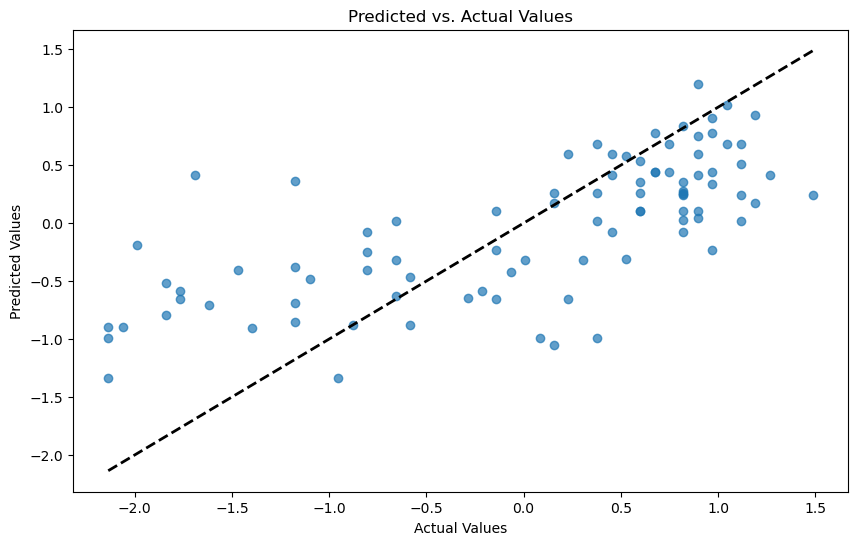

In [ ]:
# Assuming you have a test set: X_test, y_test
y_pred = final_lasso.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()


### 5.3 Random Forest

In [ ]:
# Train a Random Forest Regressor
model_rfr = RandomForestRegressor(random_state=42)

rfr_baseline_results = cross_validate(
    model_rfr, X, y,
    cv=outer_cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

print_results(rfr_baseline_results, "Random Forest Regressor (no tuning)")

Random Forest Regressor (no tuning)
MAE: 0.4787 ± 0.0264
MSE: 0.4257 ± 0.0517
R2: 0.5658 ± 0.0810


**Using GridSearchCV to Improve Model Performance**

In [ ]:
param_grid = {
    'n_estimators':      [100, 200],
    'max_depth':         [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf':  [1, 2, 4],
    'max_features':      ['sqrt', 0.8]
}

rfr_gscv = GridSearchCV(estimator=model_rfr, param_grid=param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

rfr_cv_results = cross_validate(
    rfr_gscv, X, y,
    cv=outer_cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

print_results(rfr_cv_results, "Random Forest Regressor (tuning)")

Random Forest Regressor (tuning)
MAE: 0.4818 ± 0.0253
MSE: 0.4119 ± 0.0510
R2: 0.5787 ± 0.0859


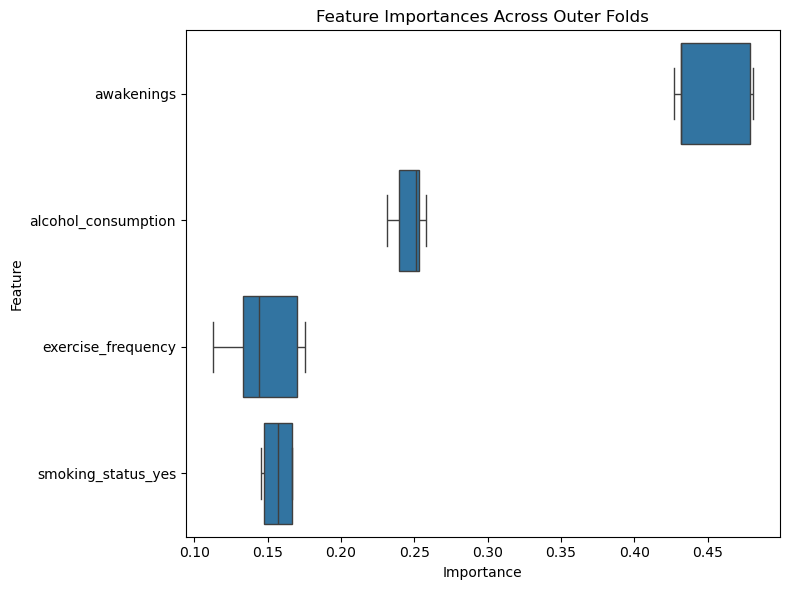

In [ ]:
# grab each outer‐fold’s fitted estimator:
all_imps = np.vstack([
    est.best_estimator_.feature_importances_
    for est in rfr_cv_results['estimator']
])

df_imps = pd.DataFrame(all_imps, columns=X.columns)
df_melt = df_imps.melt(var_name='Feature', value_name='Importance')

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_melt, x='Importance', y='Feature', orient='h')
plt.title('Feature Importances Across Outer Folds')
plt.tight_layout()
plt.show()

**Features importances**

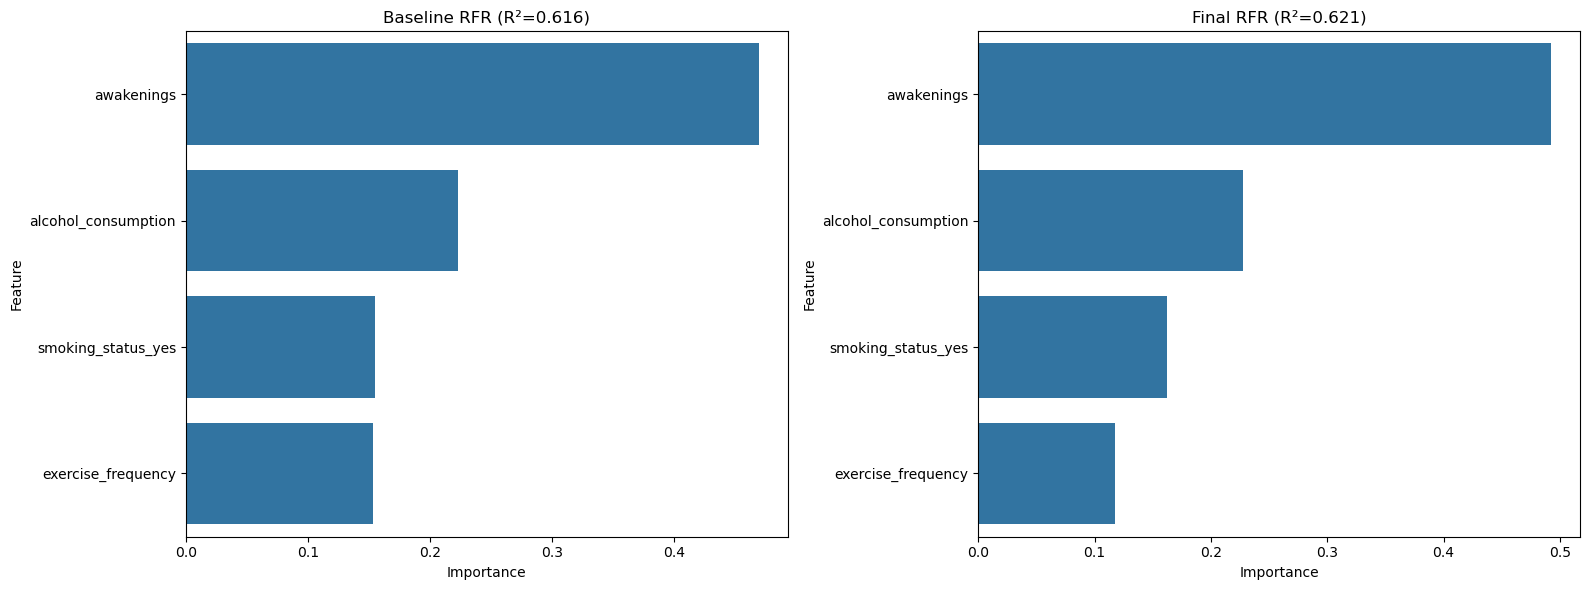

In [ ]:
final_rfr = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=inner_cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0,
    refit=True
).fit(X_train, y_train)


base_rfr = RandomForestRegressor(random_state=42).fit(X_train, y_train)

feature_importances_baseline = pd.DataFrame({
    'Feature': X.columns,
    'Importance': base_rfr.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances_global = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_rfr.best_estimator_.feature_importances_
}).sort_values(by='Importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x='Importance', y='Feature', data=feature_importances_baseline, ax=axes[0])
axes[0].set_title(f'Baseline RFR (R²={r2_score(y_test, base_rfr.predict(X_test)):.3f})')
sns.barplot(x='Importance', y='Feature', data=feature_importances_global, ax=axes[1])
axes[1].set_title(f'Final RFR (R²={r2_score(y_test, final_rfr.predict(X_test)):.3f})')

plt.tight_layout()
plt.show()

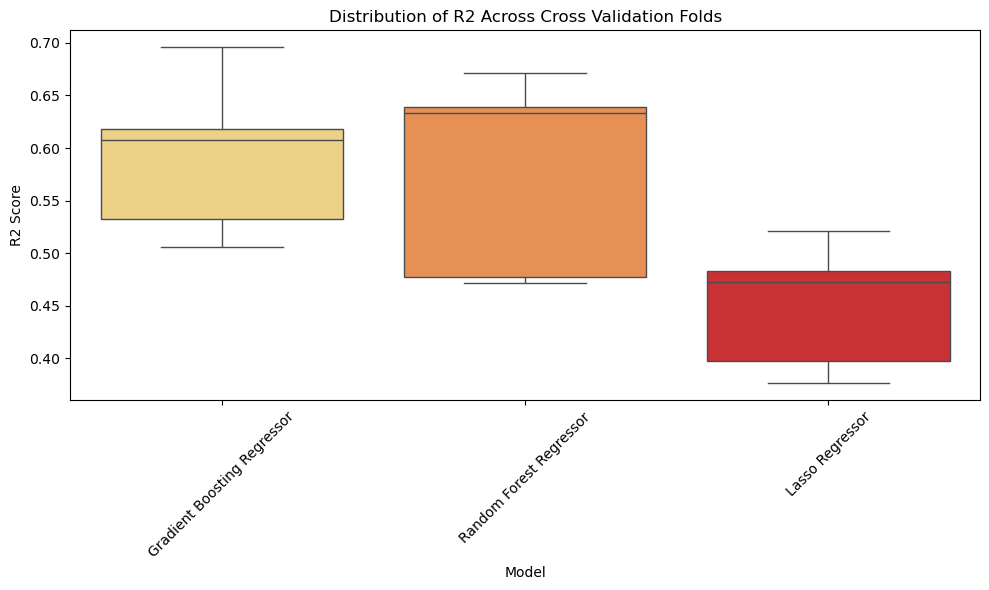

In [ ]:
# Create a boxplot with the distributionof R2 across cross validation folds 
# for the final model "rfr_final", "rfr_baseline" and "gbr_final"
# The cv_results can be found in the variables "gbr_cv_results", "rfr_cv_results" and "lasso_cv_results"

cv_results = {
    'Gradient Boosting Regressor': gbr_cv_results,
    'Random Forest Regressor': rfr_cv_results,
    'Lasso Regressor': lasso_cv_results
}

cv_results_df = pd.DataFrame({
    'Model': [],
    'R2': []
})

for model_name, results in cv_results.items():
    r2_scores = results['test_R2']
    model_df = pd.DataFrame({
        'Model': [model_name] * len(r2_scores),
        'R2': r2_scores
    })
    cv_results_df = pd.concat([cv_results_df, model_df], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='R2', data=cv_results_df, palette='YlOrRd', hue='Model')
plt.title('Distribution of R2 Across Cross Validation Folds')
plt.ylabel('R2 Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


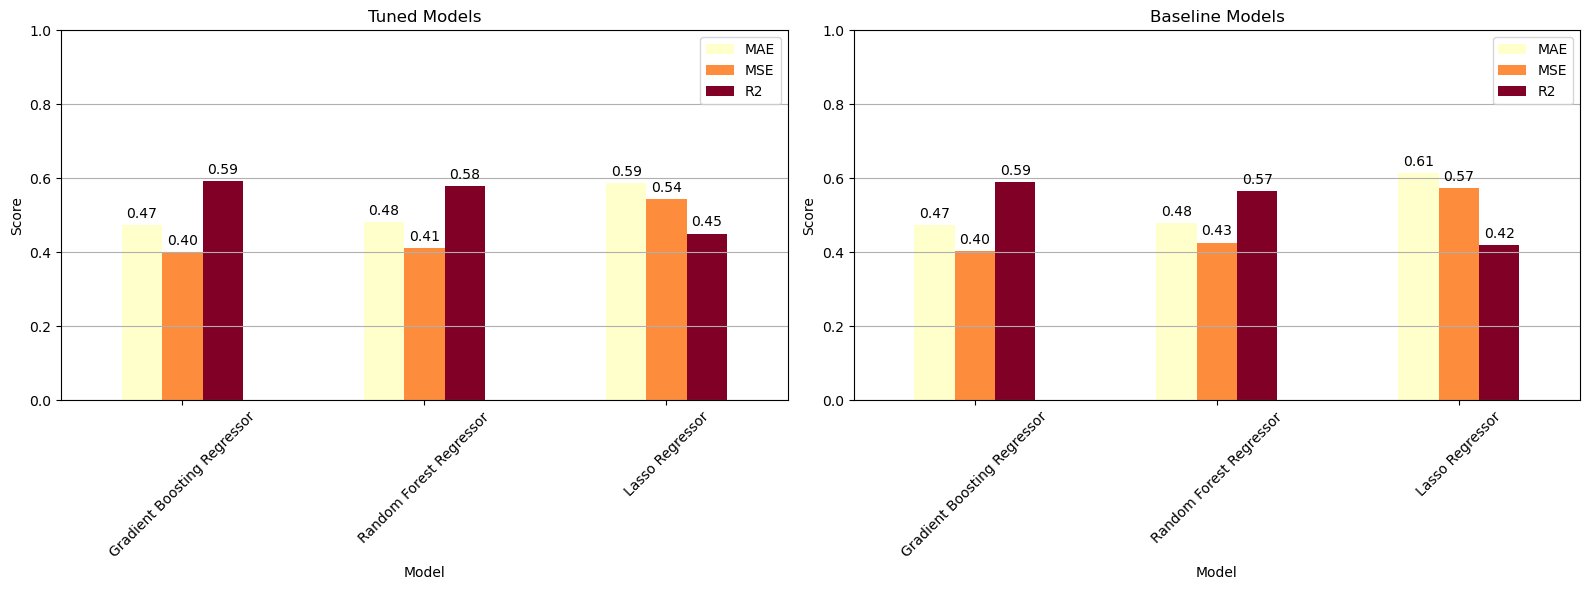

GBR: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 200, 'subsample': 1.0}
RFR: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Lasso: 0.01


In [ ]:
tuned = {
    'Gradient Boosting Regressor': gbr_cv_results,
    'Random Forest Regressor':     rfr_cv_results,
    'Lasso Regressor':             lasso_cv_results
}

baseline = {
    'Gradient Boosting Regressor': gbr_baseline_results,
    'Random Forest Regressor':     rfr_baseline_results,
    'Lasso Regressor':             lasso_baseline_results
}

# Create two dataframes to store the results of the models
tuned_df = pd.DataFrame([
    {
        'Model': name,
        'MAE':  results['test_MAE'].mean(),
        'MSE':  results['test_MSE'].mean(),
        'R2':   results['test_R2'].mean(),
    }
    for name, results in tuned.items()
])

baseline_df = pd.DataFrame([
    {
        'Model': name,
        'MAE':  results['test_MAE'].mean(),
        'MSE':  results['test_MSE'].mean(),
        'R2':   results['test_R2'].mean(),
    }
    for name, results in baseline.items()
])

# Create two barplots to compare the results of the models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

tuned_df.plot(x='Model', kind='bar', ax=axes[0], colormap='YlOrRd', title='Tuned Models', ylabel='Score', xlabel='Model', legend=True, ylim=(0, 1), rot=45)
axes[0].grid(axis='y')
baseline_df.plot(x='Model', kind='bar', ax=axes[1], colormap='YlOrRd', title='Baseline Models', ylabel='Score', xlabel='Model', legend=True, ylim=(0, 1), rot=45)
axes[1].grid(axis='y')

# Add values on top of the bars
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()

# Print Best Parameters for each model
print(f"GBR: {final_gbr.best_params_}")
print(f"RFR: {final_rfr.best_params_}")
print(f"Lasso: {final_lasso.alpha_}")

### 5.4 Results and Model Comparison

We compared three machine learning models: **Lasso Regression**, **Gradient Boosting**, and **Random Forest**. All models were evaluated using **5-fold cross-validation**, with hyperparameter tuning applied via `GridSearchCV` (for tree-based models) and `LassoCV`.

**Performance Overview**

Baseline:

| Model                       | MAE  | MSE  | R²   |
| --------------------------- | ---- | ---- | ---- |
| Gradient Boosting Regressor | 0.47 | 0.40 | 0.59 |
| Random Forest Regressor     | 0.48 | 0.43 | 0.57 |
| Lasso Regressor             | 0.61 | 0.57 | 0.42 |

Tuned:

| Model                       | MAE  | MSE  | R²   |
| --------------------------- | ---- | ---- | ---- |
| Gradient Boosting Regressor | 0.47 | 0.40 | 0.60 |
| Random Forest Regressor     | 0.48 | 0.41 | 0.58 |
| Lasso Regressor             | 0.59 | 0.54 | 0.45 |


### 5.5 Conclusion

Tree-based models significantly outperform Lasso. Either Gradient Boosting or Random Forest could be used moving forward. Future work may include ensembling or deeper analysis of feature importance and interpretability.